In [283]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from sklearn.metrics import confusion_matrix,classification_report, roc_auc_score

warnings.filterwarnings('ignore')

In [284]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier,RandomForestClassifier,BaggingClassifier,ExtraTreesClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC
import lightgbm as lgb
from sklearn.ensemble import VotingClassifier


In [285]:
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score
from sklearn.model_selection import KFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier


In [286]:
df = pd.read_csv('hotel_cleaned_data_set_final_for_model.csv')
df.head()
df.shape

(118981, 35)

In [287]:
df1 = df.sample(frac=0.5)
df1.shape

(59490, 35)

In [288]:
df1['is_canceled'].value_counts(normalize=True)


0    0.631804
1    0.368196
Name: is_canceled, dtype: float64

# X/y Split and Mteric Selection

In [289]:
X = df1.drop(['is_canceled'], axis = 1)
y = df1['is_canceled']

To select the appropriate evaluation metric, we need to understand about the risk of false negative and false positive in our prediction case. In short term point-of-view (POV), false negative of booking cancellation prediction is more likely resulting in profit-loss because of unnecessary preparation of the hotel towards non-existent customer. But in the long term POV, failing to prepare for the customer's arrival also will reduce our customer's experience, resulting in unseen profit/opportunity-loss in the future (false positive). So, balancing false positive and false negative (F1 score) is necessity for this prediction model building.

Thus we select F1 score as our performance metric in addition to accuracy (primary)

# Balancing Method


In [290]:
def balance_train_data(X, y, method=None):
    '''
    Balances the data passed in according to the specified method.
    Returns balanced numpy arrays.
    '''
    if method == None:
        return X, y

    elif method == 'undersampling':
        rus = RandomUnderSampler()
        X_train, y_train = rus.fit_resample(X, y)
        return X_train, y_train

    elif method == 'oversampling':
        ros = RandomOverSampler()
        X_train, y_train = ros.fit_resample(X, y)
        return X_train, y_train

    elif method == 'smote':
        smote = SMOTE()
        X_train, y_train = smote.fit_resample(X, y)
        return X_train, y_train

    elif method == 'both':
        smote = SMOTE(sampling_strategy=0.75)
        under = RandomUnderSampler(sampling_strategy=1)
        X_train, y_train = smote.fit_resample(X, y)
        X_train, y_train = under.fit_resample(X_train, y_train)
        return X_train, y_train

    else:
        print('Incorrect balance method')
        return

In [291]:
def plot_cross_val(models, X, y, ax, sampling_method, names, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True)


    precisions = []
    recalls = []
    f1 = []
    for i in range(len(models)):
        precisions.append([])
        recalls.append([])
        f1.append([])

    for train, test in kf.split(X):
        X_test, y_test = X.iloc[test], y.iloc[test]
        X_train, y_train = X.iloc[train], y.iloc[train]
        
        X_train, y_train = balance_train_data(X_train, y_train, method=sampling_method)

        for i, model in enumerate(models):
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # precisions[i].append(precision_score(y_test, y_pred))
            # recalls[i].append(recall_score(y_test, y_pred))
            f1[i].append(f1_score(y_test, y_pred))

    x = range(0, n_splits)
    colormap = {0 : 'r',
                1 : 'b',
                2 : 'g',
                3 : 'c',
                4 : 'm'}


    for i in range(len(models)):
        print(f1[i])
        ax.plot(x, f1[i], c=colormap[i],
                linewidth=1, linestyle='-',
                label='%s F1 Score' % names[i])
        # ax.plot(x, precisions[i], c=colormap[i],
        #        linewidth=1, linestyle='-',
        #        label='%s Precision' % names[i])
        # ax.plot(x, recalls[i], c=colormap[i],
        #        linewidth=1, linestyle='--',
        #        label='%s Recall' % names[i])

To find the effect of balancing will use logistic regression as our basic binary classification model, KNN as instance-based machine learning model, Forest as bagging ensemble method, and XGBoost as boosting ensemble method.

In [292]:
models = [LogisticRegression(), KNeighborsClassifier(), RandomForestClassifier(), XGBClassifier()]


[20:58:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:59:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:59:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:59:33] WARNING: /Users/runner/miniforge3/cond

Text(0.5, 1.0, 'No Balancing')

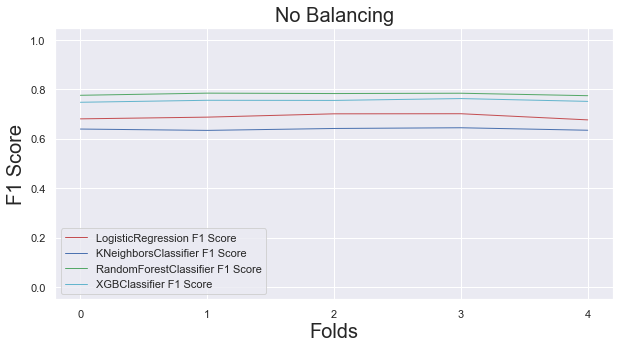

In [293]:
fig, ax = plt.subplots(figsize=(10, 5))

plot_cross_val(models, X, y, ax, None, [m.__class__.__name__ for m in models])
ax.legend()
ax.set_ylim(-0.05, 1.05)
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xlabel('Folds', fontsize=20)
ax.set_ylabel('F1 Score', fontsize=20)
ax.set_title('No Balancing', fontsize=20)



[21:00:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:00:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:00:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:00:46] WARNING: /Users/runner/miniforge3/cond

Text(0.5, 1.0, 'Undersampling')

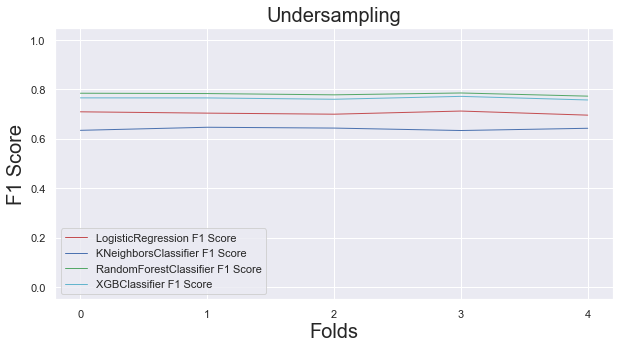

In [294]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_cross_val(models, X, y, ax, 'undersampling', [m.__class__.__name__ for m in models])
ax.legend()
ax.set_ylim(-0.05, 1.05)
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xlabel('Folds', fontsize=20)
ax.set_ylabel('F1 Score', fontsize=20)
ax.set_title('Undersampling', fontsize=20)

[21:01:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:01:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:01:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:02:19] WARNING: /Users/runner/miniforge3/cond

Text(0.5, 1.0, 'Oversampling')

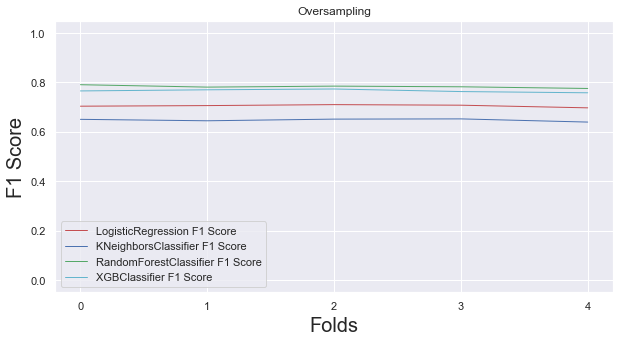

In [295]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_cross_val(models, X, y, ax, 'oversampling', [m.__class__.__name__ for m in models])
ax.legend()
ax.set_ylim(-0.05, 1.05)
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xlabel('Folds', fontsize=20)
ax.set_ylabel('F1 Score', fontsize=20)
ax.set_title('Oversampling')

[21:03:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:03:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:04:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:04:26] WARNING: /Users/runner/miniforge3/cond

Text(0.5, 1.0, 'SMOTE')

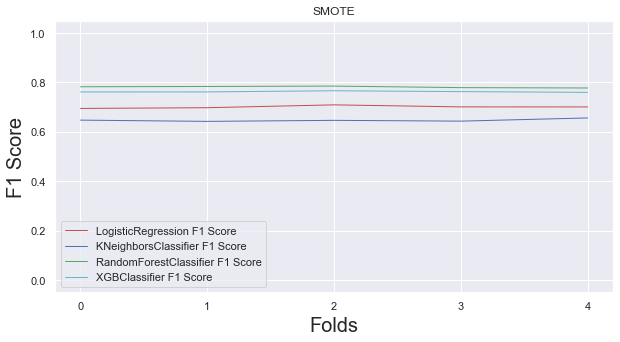

In [296]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_cross_val(models, X, y, ax, 'smote', [m.__class__.__name__ for m in models])
ax.legend()
ax.set_ylim(-0.05, 1.05)
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xlabel('Folds', fontsize=20)
ax.set_ylabel('F1 Score', fontsize=20)
ax.set_title('SMOTE')

[21:05:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:05:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:05:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:06:15] WARNING: /Users/runner/miniforge3/cond

Text(0.5, 1.0, 'SMOTE + Undersampling')

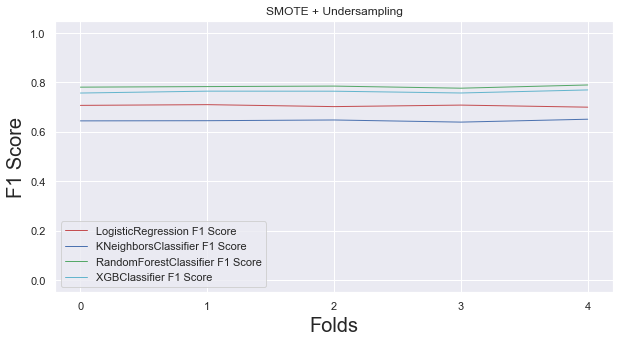

In [297]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_cross_val(models, X, y, ax, 'both', [m.__class__.__name__ for m in models])
ax.legend()
ax.set_ylim(-0.05, 1.05)
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xlabel('Folds', fontsize=20)
ax.set_ylabel('F1 Score', fontsize=20)
ax.set_title('SMOTE + Undersampling')

Not balancing the data actually doesn't make much of a difference, so I decided to move forward with the data as is. It is likely that this is the case because the data is not too imbalanced.

# Train/Test Split

In [298]:
# Train and test split data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42,stratify = y,test_size = 0.30)

# Model Building

### XGBoost

In [299]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

[21:15:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [300]:
training_acc_xgb=xgb.score(X_train,y_train)
testing_acc_xgb=xgb.score(X_test,y_test)

y_predicted=xgb.predict(X_test)

recall_xgb=recall_score(y_test,y_predicted)
accuracy_xgb=accuracy_score(y_test,y_predicted)
precision_xgb=precision_score(y_test,y_predicted)
f1_xgb=f1_score(y_test,y_predicted)

print(f"Training Accuracy : {training_acc_xgb}")
print(f"Testing Accuracy : {testing_acc_xgb}")

#Model is not over or under fitting

Training Accuracy : 0.8651874264582283
Testing Accuracy : 0.8369473861153135


<AxesSubplot:>

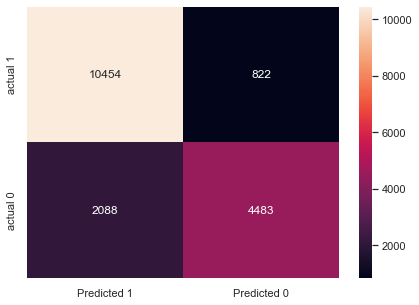

In [301]:

cm=confusion_matrix(y_test, y_predicted)
df_stacked_model = pd.DataFrame(data = cm, index = ['actual 1', 'actual 0'], columns = ['Predicted 1', 'Predicted 0'])


plt.figure(figsize = (7, 5))
sns.heatmap(df_stacked_model, annot = True,fmt='g')

In [302]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88     11276
           1       0.85      0.68      0.75      6571

    accuracy                           0.84     17847
   macro avg       0.84      0.80      0.82     17847
weighted avg       0.84      0.84      0.83     17847



### LGB

In [303]:
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train,y_train)

LGBMClassifier()

In [304]:
training_acc_lgb=lgb_model.score(X_train,y_train)
testing_acc_lgb=lgb_model.score(X_test,y_test)

y_predicted=lgb_model.predict(X_test)

recall_lgb=recall_score(y_test,y_predicted)
accuracy_lgb=accuracy_score(y_test,y_predicted)
precision_lgb=precision_score(y_test,y_predicted)
f1_lgb=f1_score(y_test,y_predicted)

print(f"Training Accuracy : {training_acc_lgb}")
print(f"Testing Accuracy : {testing_acc_lgb}")

#Model is not overfitting or underfitting

Training Accuracy : 0.8434550824868525
Testing Accuracy : 0.8339776993332213


<AxesSubplot:>

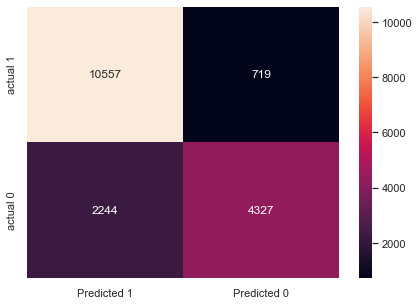

In [305]:

cm=confusion_matrix(y_test, y_predicted)
df_stacked_model = pd.DataFrame(data = cm, index = ['actual 1', 'actual 0'], columns = ['Predicted 1', 'Predicted 0'])


plt.figure(figsize = (7, 5))
sns.heatmap(df_stacked_model, annot = True,fmt='g')

In [306]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.82      0.94      0.88     11276
           1       0.86      0.66      0.74      6571

    accuracy                           0.83     17847
   macro avg       0.84      0.80      0.81     17847
weighted avg       0.84      0.83      0.83     17847



### Decision Tree

In [307]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train,y_train)

DecisionTreeClassifier()

In [308]:
training_acc_dt=dt_model.score(X_train,y_train)
testing_acc_dt=dt_model.score(X_test,y_test)

y_predicted=dt_model.predict(X_test)

recall_dt=recall_score(y_test,y_predicted)
accuracy_dt=accuracy_score(y_test,y_predicted)
precision_dt=precision_score(y_test,y_predicted)
f1_dt=f1_score(y_test,y_predicted)

print(f"Training Accuracy : {training_acc_dt}")
print(f"Testing Accuracy : {testing_acc_dt}")

#Model is overfitting

Training Accuracy : 0.9923396489205869
Testing Accuracy : 0.794251134644478


<AxesSubplot:>

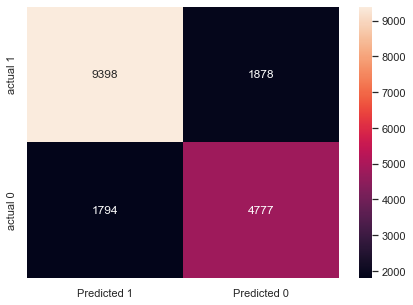

In [309]:

cm=confusion_matrix(y_test, y_predicted)
df_stacked_model = pd.DataFrame(data = cm, index = ['actual 1', 'actual 0'], columns = ['Predicted 1', 'Predicted 0'])


plt.figure(figsize = (7, 5))
sns.heatmap(df_stacked_model, annot = True,fmt='g')

In [310]:

print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.84      0.83      0.84     11276
           1       0.72      0.73      0.72      6571

    accuracy                           0.79     17847
   macro avg       0.78      0.78      0.78     17847
weighted avg       0.79      0.79      0.79     17847



### RandomForest

In [311]:
rf_model = RandomForestClassifier( )
rf_model.fit(X_train,y_train)

RandomForestClassifier()

In [312]:
training_acc_rf=rf_model.score(X_train,y_train)
testing_acc_rf=rf_model.score(X_test,y_test)

y_predicted=rf_model.predict(X_test)

recall_rf=recall_score(y_test,y_predicted)
accuracy_rf=accuracy_score(y_test,y_predicted)
precision_rf=precision_score(y_test,y_predicted)
f1_rf=f1_score(y_test,y_predicted)

print(f"Training Accuracy : {training_acc_rf}")
print(f"Testing Accuracy : {testing_acc_rf}")

#Model is overfitting

Training Accuracy : 0.9923396489205869
Testing Accuracy : 0.8477054967221381


<AxesSubplot:>

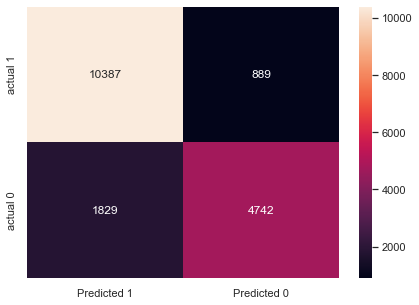

In [313]:

cm=confusion_matrix(y_test, y_predicted)
df_stacked_model = pd.DataFrame(data = cm, index = ['actual 1', 'actual 0'], columns = ['Predicted 1', 'Predicted 0'])


plt.figure(figsize = (7, 5))
sns.heatmap(df_stacked_model, annot = True,fmt='g')

In [314]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88     11276
           1       0.84      0.72      0.78      6571

    accuracy                           0.85     17847
   macro avg       0.85      0.82      0.83     17847
weighted avg       0.85      0.85      0.84     17847



### SVC

In [315]:
svc_model = SVC( )
svc_model.fit(X_train,y_train)

SVC()

In [316]:
training_acc_svc=svc_model.score(X_train,y_train)
testing_acc_svc=svc_model.score(X_test,y_test)

y_predicted=svc_model.predict(X_test)

recall_svc=recall_score(y_test,y_predicted)
accuracy_svc=accuracy_score(y_test,y_predicted)
precision_svc=precision_score(y_test,y_predicted)
f1_svc=f1_score(y_test,y_predicted)

print(f"Training Accuracy : {training_acc_svc}")
print(f"Testing Accuracy : {testing_acc_svc}")

#Model is not overfitting

Training Accuracy : 0.6878226832841053
Testing Accuracy : 0.6889113016193198


<AxesSubplot:>

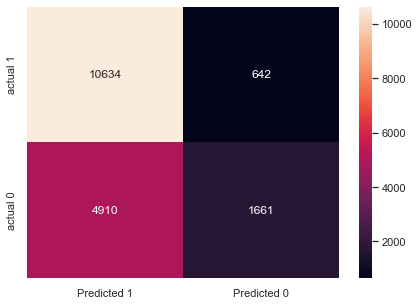

In [317]:

cm=confusion_matrix(y_test, y_predicted)
df_stacked_model = pd.DataFrame(data = cm, index = ['actual 1', 'actual 0'], columns = ['Predicted 1', 'Predicted 0'])


plt.figure(figsize = (7, 5))
sns.heatmap(df_stacked_model, annot = True,fmt='g')

In [318]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.68      0.94      0.79     11276
           1       0.72      0.25      0.37      6571

    accuracy                           0.69     17847
   macro avg       0.70      0.60      0.58     17847
weighted avg       0.70      0.69      0.64     17847



### Logistic Regression

In [319]:
lreg_model = LogisticRegression( )
lreg_model.fit(X_train,y_train)

LogisticRegression()

In [320]:
training_acc_lreg=lreg_model.score(X_train,y_train)
testing_acc_lreg=lreg_model.score(X_test,y_test)

y_predicted=lreg_model.predict(X_test)

recall_lreg=recall_score(y_test,y_predicted)
accuracy_lreg=accuracy_score(y_test,y_predicted)
precision_lreg=precision_score(y_test,y_predicted)
f1_lreg=f1_score(y_test,y_predicted)

print(f"Training Accuracy : {training_acc_lreg}")
print(f"Testing Accuracy : {testing_acc_lreg}")

#Model is not overfitting or underfitting

Training Accuracy : 0.7980212760848162
Testing Accuracy : 0.7995741581218132


<AxesSubplot:>

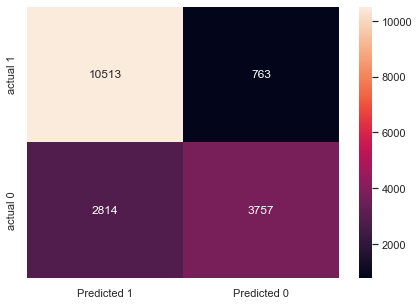

In [321]:

cm=confusion_matrix(y_test, y_predicted)
df_stacked_model = pd.DataFrame(data = cm, index = ['actual 1', 'actual 0'], columns = ['Predicted 1', 'Predicted 0'])


plt.figure(figsize = (7, 5))
sns.heatmap(df_stacked_model, annot = True,fmt='g')

In [322]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.79      0.93      0.85     11276
           1       0.83      0.57      0.68      6571

    accuracy                           0.80     17847
   macro avg       0.81      0.75      0.77     17847
weighted avg       0.80      0.80      0.79     17847



### AdaBoost

In [323]:

adaboost_model = AdaBoostClassifier()

# Fit the classifier to the data
adaboost_model.fit(X_train, y_train)

AdaBoostClassifier()

In [324]:
training_acc_adaboost_model=adaboost_model.score(X_train,y_train)
testing_acc_adaboost_model=adaboost_model.score(X_test,y_test)

y_predicted=adaboost_model.predict(X_test)

recall_adaboost_model=recall_score(y_test,y_predicted)
accuracy_adaboost_model=accuracy_score(y_test,y_predicted)
precision_adaboost_model=precision_score(y_test,y_predicted)
f1_adaboost_model=f1_score(y_test,y_predicted)

print(f"Training Accuracy : {training_acc_adaboost_model}")
print(f"Testing Accuracy : {testing_acc_adaboost_model}")

#Model is  overfitting 

Training Accuracy : 0.8154791921811589
Testing Accuracy : 0.8135821146411162


### Bagging Classifier

In [325]:
bagging_model = BaggingClassifier()

# Fit the classifier to the data
bagging_model.fit(X_train, y_train)

BaggingClassifier()

In [326]:
training_acc_bagging_model=bagging_model.score(X_train,y_train)
testing_acc_bagging_model=bagging_model.score(X_test,y_test)

y_predicted=bagging_model.predict(X_test)

recall_bagging_model=recall_score(y_test,y_predicted)
accuracy_bagging_model=accuracy_score(y_test,y_predicted)
precision_bagging_model=precision_score(y_test,y_predicted)
f1_bagging_model=f1_score(y_test,y_predicted)

print(f"Training Accuracy : {training_acc_bagging_model}")
print(f"Testing Accuracy : {testing_acc_bagging_model}")

#Model is  overfitting 

Training Accuracy : 0.9796844607737195
Testing Accuracy : 0.8363870678545414


<AxesSubplot:>

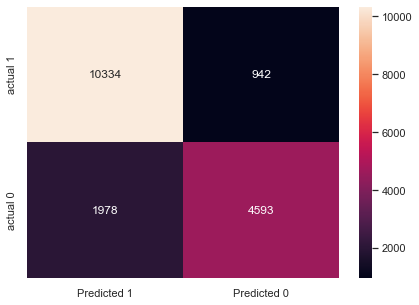

In [327]:

cm=confusion_matrix(y_test, y_predicted)
df_stacked_model = pd.DataFrame(data = cm, index = ['actual 1', 'actual 0'], columns = ['Predicted 1', 'Predicted 0'])


plt.figure(figsize = (7, 5))
sns.heatmap(df_stacked_model, annot = True,fmt='g')

In [328]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88     11276
           1       0.83      0.70      0.76      6571

    accuracy                           0.84     17847
   macro avg       0.83      0.81      0.82     17847
weighted avg       0.84      0.84      0.83     17847




#  Comparing Each Models Evaluation Matrix

In [329]:
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [330]:
evaluation_matrix_base = {
    'Logistic Regression': [accuracy_lreg, recall_lreg, precision_lreg, f1_lreg],
    'SVC':[accuracy_svc,recall_svc,precision_svc, f1_svc],
    'Decision Tree':[accuracy_dt, recall_dt, precision_dt, f1_dt],
    'Random Forest':[accuracy_rf, recall_rf, precision_rf, f1_rf],
    'XGB':[accuracy_xgb, recall_xgb, precision_xgb, f1_xgb],
    'LGB':[accuracy_lgb, recall_lgb, precision_lgb, f1_lgb],
    'Bagging Classifier':[accuracy_bagging_model, recall_bagging_model, precision_bagging_model, f1_bagging_model],

}


eva_base = pd.DataFrame(data = evaluation_matrix_base, index = ['Accuracy', 'Recall', 'Precision', 'F1 Score'])

evaluation_matrix_base_training = {
    "training" : [training_acc_lreg, training_acc_svc, training_acc_dt, training_acc_rf, training_acc_xgb,training_acc_lgb,training_acc_bagging_model],
    "testing": [testing_acc_lreg, testing_acc_svc, testing_acc_dt, testing_acc_rf, testing_acc_xgb,testing_acc_lgb,testing_acc_bagging_model]
}
    

eva_base_train = pd.DataFrame(data = evaluation_matrix_base_training, index = ['Logistic Regresion', 'SVC', 'Decision Tree', 'Random Forest', 'XGB','LGB','Bagging Classifier'])

print()
display_side_by_side([eva_base], ['Evaluation Matrix'])
print("\n")
display_side_by_side([eva_base_train], ['Accuracy Train & Test'])



,Logistic Regression,SVC,Decision Tree,Random Forest,XGB,LGB,Bagging Classifier
Accuracy,0.799574,0.688911,0.794251,0.847705,0.836947,0.833978,0.836387
Recall,0.571755,0.252777,0.726982,0.721656,0.682240,0.658499,0.698980
Precision,0.831195,0.721233,0.717806,0.842124,0.845052,0.857511,0.829810
F1 Score,0.677486,0.374352,0.722365,0.777250,0.754968,0.744943,0.758797


,training,testing
Logistic Regresion,0.798021,0.799574
SVC,0.687823,0.688911
Decision Tree,0.992340,0.794251
Random Forest,0.992340,0.847705
XGB,0.865187,0.836947
LGB,0.843455,0.833978
Bagging Classifier,0.979684,0.836387


# Applying Hyper Parameter Tuning using Grid SeachCV for  alogorithms to check best score and best parameters


In [331]:
from sklearn.model_selection import GridSearchCV
met_grid= {"F1": "f1", "Accuracy": "accuracy"}


### XGB

In [332]:
param_grid ={ 'max_depth': [3, 4, 5],'learning_rate': [0.1, 0.01],'n_estimators': [50, 100, 200]}
clf_xgb = GridSearchCV(estimator= xgb, param_grid = param_grid, cv = 3, n_jobs=-1, scoring=met_grid ,refit='Accuracy')
best_clf_xgb = clf_xgb.fit(X_train,y_train)
print('XGBOOST Best score: {} using best parameters {}'.format(best_clf_xgb.best_score_, best_clf_xgb.best_params_))

/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hansikarunarathna/opt/anaconda3/lib/p

[21:28:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:34] WARNING: /Users/runner/miniforge3/cond

/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hansikarunarathna/opt/anaconda3/lib/p

[21:28:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hansikarunarathna/opt/anaconda3/lib/p

[21:28:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:28:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:28:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:28:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:28:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:28:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:28:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:28:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:28:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:29:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:29:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:29:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:29:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:29:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:29:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:29:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:29:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:29:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:29:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:29:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:29:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:29:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:29:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hansikarunarathna/opt/anaconda3/lib/p

[21:29:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:29:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:29:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:29:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:29:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:29:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:29:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:29:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:29:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:29:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:29:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:29:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:29:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:29:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:29:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBOOST Best score: 0.8283024758062579 using best parameters {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


In [333]:
XGB_tuned = clf_xgb.best_estimator_
y_pred_XGB_tuned = XGB_tuned.predict(X_test)

train_accuracy_XGB_tuned = XGB_tuned.score(X_train, y_train)
test_accuracy_XGB_tuned = XGB_tuned.score(X_test, y_test)
f1_XGB_tuned = f1_score(y_test, y_pred_XGB_tuned)


print(f"Training Accuracy : {train_accuracy_XGB_tuned}")
print(f"Testing Accuracy : {test_accuracy_XGB_tuned}")
print(f"F1 Score : {f1_XGB_tuned}")



Training Accuracy : 0.8373796316307662
Testing Accuracy : 0.8281503894211912
F1 Score : 0.7340213337958545


### LGB

In [334]:
param_grid ={'n_estimators':[10, 50, 100,500],'learning_rate': [0.0001, 0.001, 0.01, 0.1,1],'max_depth': [1,3,4,5]}
clf_lgb = GridSearchCV(estimator= lgb_model, param_grid = param_grid, cv = 3, n_jobs=-1, scoring=met_grid ,refit='Accuracy')
best_clf_lgb = clf_lgb.fit(X_train,y_train)
print('LGB Best score: {} using best parameters {}'.format(best_clf_lgb.best_score_, best_clf_lgb.best_params_))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

In [335]:
LGB_tuned = clf_lgb.best_estimator_
y_pred_LGB_tuned = LGB_tuned.predict(X_test)

train_accuracy_LGB_tuned = LGB_tuned.score(X_train, y_train)
test_accuracy_LGB_tuned = LGB_tuned.score(X_test, y_test)
f1_LGB_tuned = f1_score(y_test, y_pred_LGB_tuned)


print(f"Training Accuracy : {train_accuracy_LGB_tuned}")
print(f"Testing Accuracy : {test_accuracy_LGB_tuned}")
print(f"F1 Score : {f1_LGB_tuned}")



Training Accuracy : 0.8643229354273227
Testing Accuracy : 0.8383481817672438
F1 Score : 0.7577462423377278


### Random Forest

In [336]:

param_grid = [{'min_samples_split': [2,4,8,10],'max_depth': [5,10,15],'min_samples_leaf': [2,4,8,10]}]

clf_rf = GridSearchCV(estimator= rf_model, param_grid = param_grid, cv = 3, n_jobs=-1, scoring=met_grid ,refit='Accuracy')
best_clf_rf = clf_rf.fit(X_train,y_train)
print(' Random Forest Best  score: {} using best parameters {}'.format(best_clf_rf.best_score_, best_clf_rf.best_params_))

 Random Forest Best  score: 0.8296232259923637 using best parameters {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [337]:
RF_tuned = clf_rf.best_estimator_
y_pred_RF_tuned = RF_tuned.predict(X_test)

train_accuracy_RF_tuned = RF_tuned.score(X_train, y_train)
test_accuracy_RF_tuned = RF_tuned.score(X_test, y_test)
f1_RF_tuned = f1_score(y_test, y_pred_RF_tuned)


print(f"Training Accuracy : {train_accuracy_RF_tuned}")
print(f"Testing Accuracy : {test_accuracy_RF_tuned}")
print(f"F1 Score : {f1_RF_tuned}")




Training Accuracy : 0.8411017457916097
Testing Accuracy : 0.8312881716815151
F1 Score : 0.7344094557643116


### Logistic Regresion

In [338]:

param_grid = [{'penalty': ['l2','l1','elasticent'],'C': [1.0, 2.0, 3.0, 5,0.5, 0.1],'class_weight': [None, 'balanced'],'max_iter': [500,2000,4000]}]
clf_lgr = GridSearchCV(estimator= lreg_model, param_grid = param_grid, cv = 3, n_jobs=-1, scoring=met_grid ,refit='Accuracy')
best_clf_lgr = clf_lgr.fit(X_train,y_train)
print('Logistic Regression Best score: {} using best parameters {}'.format(best_clf_lgr.best_score_, best_clf_lgr.best_params_))

/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Logistic Regression Best score: 0.8092836731263358 using best parameters {'C': 5, 'class_weight': None, 'max_iter': 500, 'penalty': 'l2'}


In [339]:
LRG_tuned = clf_lgr.best_estimator_
y_pred_LRG_tuned = LRG_tuned.predict(X_test)

train_accuracy_LRG_tuned = LRG_tuned.score(X_train, y_train)
test_accuracy_LRG_tuned = LRG_tuned.score(X_test, y_test)
f1_LRG_tuned = f1_score(y_test, y_pred_LRG_tuned)


print(f"Training Accuracy : {train_accuracy_LRG_tuned}")
print(f"Testing Accuracy : {test_accuracy_LRG_tuned}")
print(f"F1 Score : {f1_LRG_tuned}")




Training Accuracy : 0.8089234685301251
Testing Accuracy : 0.8063540090771558
F1 Score : 0.6918687589158344


### Decision Tree

In [340]:

param_grid = [{'min_samples_split': [6,8,10,12,20],'max_depth': [5,10,15],'min_samples_leaf': [2,4,6,8,10,12,20]}]

clf_dt = GridSearchCV(estimator= dt_model, param_grid = param_grid, cv = 3, n_jobs=-1, scoring=met_grid ,refit='Accuracy')
best_clf_dt = clf_dt.fit(X_train,y_train)
print('Decision Tree Best score: {} using best parameters {}'.format(best_clf_dt.best_score_, best_clf_dt.best_params_))

Decision Tree Best score: 0.8182647743918546 using best parameters {'max_depth': 15, 'min_samples_leaf': 20, 'min_samples_split': 6}


In [341]:
DT_tuned = clf_dt.best_estimator_
y_pred_DT_tuned = DT_tuned.predict(X_test)

train_accuracy_DT_tuned = DT_tuned.score(X_train, y_train)
test_accuracy_DT_tuned = DT_tuned.score(X_test, y_test)
f1_DT_tuned = f1_score(y_test, y_pred_DT_tuned)


print(f"Training Accuracy : {train_accuracy_DT_tuned}")
print(f"Testing Accuracy : {test_accuracy_DT_tuned}")
print(f"F1 Score : {f1_DT_tuned}")





Training Accuracy : 0.8341377902648704
Testing Accuracy : 0.8162156104667451
F1 Score : 0.7171438427043808


### ADABoost

In [142]:

param_grid = [{    'n_estimators': [50, 100, 150],'learning_rate': [0.01, 0.1, 1],'algorithm': ['SAMME', 'SAMME.R']}]

clf_adaboost_model = GridSearchCV(estimator= adaboost_model, param_grid = param_grid, cv = 3, n_jobs=-1, scoring=met_grid ,refit='Accuracy')
best_clf_adaboost_model = clf_adaboost_model.fit(X_train,y_train)
print('ADABoost Best score: {} using best parameters {}'.format(best_clf_adaboost_model.best_score_, best_clf_adaboost_model.best_params_))

ADABoost Best score: 0.8155032058209063 using best parameters {'learning_rate': 1, 'n_estimators': 100}


In [144]:
adaboost_tuned = clf_adaboost_model.best_estimator_
y_pred_KNN_tuned = adaboost_tuned.predict(X_test)

train_accuracy_adaboost_tuned = adaboost_tuned.score(X_train, y_train)
test_accuracy_adaboost_tuned = adaboost_tuned.score(X_test, y_test)
f1_adaboost_tuned = f1_score(y_test, y_pred_KNN_tuned)


print(f"Training Accuracy : {train_accuracy_adaboost_tuned}")
print(f"Testing Accuracy : {test_accuracy_adaboost_tuned}")
print(f"F1 Score : {f1_adaboost_tuned}")





Training Accuracy : 0.8174242970006964
Testing Accuracy : 0.812237350815263
F1 Score : 0.7096941869531318


### Bagging Classsifer

In [376]:

param_grid = {
    'n_estimators': [50, 80, 100],
    'max_samples': [0.3, 0.2, 0.1],
    'max_features': [0.5, 0.5, 0.1],

}

base_estimator = DecisionTreeClassifier(max_depth=10,min_samples_split=5)
bagging_model = BaggingClassifier(base_estimator=base_estimator)

clf_bagging_model = GridSearchCV(estimator= bagging_model, param_grid = param_grid, cv = 3, n_jobs=-1, scoring=met_grid ,refit='Accuracy')
best_clf_bagging_model = clf_bagging_model.fit(X_train,y_train)
print('Bagging Classifier Best score: {} using best parameters {}'.format(best_clf_bagging_model.best_score_, best_clf_bagging_model.best_params_))

Bagging Classifier Best score: 0.8133900055231371 using best parameters {'max_features': 0.5, 'max_samples': 0.3, 'n_estimators': 80}


In [378]:
bagging_tuned =BaggingClassifier(base_estimator= DecisionTreeClassifier(max_depth=10,min_samples_split=5),n_estimators=150,max_samples=0.7,max_features=0.9)
bagging_tuned.fit(X_train,y_train)

y_pred_bagging_tuned = bagging_tuned.predict(X_test)
train_accuracy_bagging_tuned = bagging_tuned.score(X_train, y_train)
test_accuracy_bagging_tuned = bagging_tuned.score(X_test, y_test)
f1_bagging_tuned = f1_score(y_test, y_pred_bagging_tuned)


print(f"Training Accuracy : {train_accuracy_bagging_tuned}")
print(f"Testing Accuracy : {test_accuracy_bagging_tuned}")
print(f"F1 Score : {f1_bagging_tuned}")


Training Accuracy : 0.8295511850731215
Testing Accuracy : 0.8232756205524738
F1 Score : 0.720042606071365


# Comparing Tuned Models

In [379]:
evaluation_matrix_tuned = {
    "Training Accuracy" : [train_accuracy_LRG_tuned, train_accuracy_DT_tuned, train_accuracy_RF_tuned, train_accuracy_XGB_tuned,train_accuracy_LGB_tuned,train_accuracy_bagging_tuned],
    "Testing Accuracy": [test_accuracy_LRG_tuned, test_accuracy_DT_tuned, test_accuracy_RF_tuned, test_accuracy_XGB_tuned,test_accuracy_LGB_tuned,test_accuracy_bagging_tuned],
    "F1": [f1_LRG_tuned, f1_DT_tuned, f1_RF_tuned, f1_XGB_tuned,f1_LGB_tuned,f1_bagging_model]

}

eva_tuned = pd.DataFrame(data = evaluation_matrix_tuned, index = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGB','LGB','Bagging Classifier'])


In [380]:
display_side_by_side([ eva_tuned], ['Tuned Models'])


,Training Accuracy,Testing Accuracy,F1
Logistic Regression,0.808923,0.806354,0.691869
Decision Tree,0.834138,0.816216,0.717144
Random Forest,0.841102,0.831288,0.734409
XGB,0.837380,0.828150,0.734021
LGB,0.864323,0.838348,0.757746
Bagging Classifier,0.829551,0.823276,0.758797


# Applying StratifiedKfold Cross Validation Technique on top 3 algorithms to know the exact mean CV accuracy score of the models



Input the best parameters obtained in hyper tuning tuning for respective alogorithms

In [346]:
from sklearn.model_selection import cross_val_score,StratifiedKFold,cross_validate
skfold = StratifiedKFold(n_splits= 5,shuffle= True,random_state= 42)


### XGB

In [347]:
xgb_model=XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators= 200)
xgb_cv_result_acc = cross_val_score(xgb_model,X, y, cv=skfold, scoring="accuracy",n_jobs=-1)
xgb_cv_acc = xgb_cv_result_acc.mean()*100

xgb_cv_result_f1 = cross_val_score(xgb_model,X, y, cv=skfold,scoring="f1",n_jobs=-1)
xgb_cv_f1 = xgb_cv_result_f1.mean()*100
print('XGBOOST CV Mean Accuracy Score is {}'.format(xgb_cv_acc))
print('XGBOOST CV F1 Score is {}'.format(xgb_cv_f1))

/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hansikarunarathna/opt/anaconda3/lib/p

[21:38:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:38:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:38:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:38:04] WARNING: /Users/runner/miniforge3/cond

/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hansikarunarathna/opt/anaconda3/lib/p

[21:38:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:38:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:38:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:38:26] WARNING: /Users/runner/miniforge3/cond

[21:38:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.82      0.94      0.87     11276
           1       0.85      0.64      0.73      6571

    accuracy                           0.83     17847
   macro avg       0.84      0.79      0.80     17847
weighted avg       0.83      0.83      0.82     17847



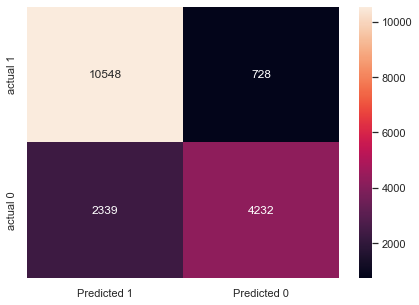

In [348]:
xgb_model.fit(X_train,y_train)
y_predicted=xgb_model.predict(X_test)

cm=confusion_matrix(y_test, y_predicted)
df_stacked_model = pd.DataFrame(data = cm, index = ['actual 1', 'actual 0'], columns = ['Predicted 1', 'Predicted 0'])


plt.figure(figsize = (7, 5))
sns.heatmap(df_stacked_model, annot = True,fmt='g')

print(classification_report(y_test, y_predicted))


### LGB

In [349]:
lgb_model=lgb.LGBMClassifier(learning_rate=0.1, max_depth= 5, n_estimators=500)

lgb_cv_result_acc = cross_val_score(lgb_model,X, y, cv=skfold, scoring="accuracy",n_jobs=-1)
lgb_cv_acc = lgb_cv_result_acc.mean()*100

lgb_cv_result_f1 = cross_val_score(xgb_model,X, y, cv=skfold,scoring="f1",n_jobs=-1)
lgb_cv_f1 = lgb_cv_result_f1.mean()*100
print('LGB CV Mean Accuracy Score is {}'.format(lgb_cv_acc))
print('LGB CV F1 Score is {}'.format(lgb_cv_f1))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hansikarunarathna/opt/anaconda3/lib/p

[21:40:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:40:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:40:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:40:07] WARNING: /Users/runner/miniforge3/cond

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
              precision    recall  f1-score   support

           0       0.84      0.93      0.88     11276
           1       0.85      0.69      0.76      6571

    accuracy                           0.84     17847
   macro avg       0.84      0.81      0.82     17847
weighted avg       0.84      0.84      0.83     17847



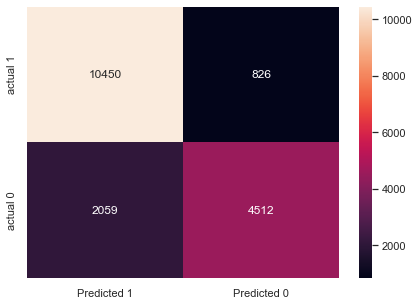

In [350]:
lgb_model.fit(X_train,y_train)
y_predicted=lgb_model.predict(X_test)

cm=confusion_matrix(y_test, y_predicted)
df_stacked_model = pd.DataFrame(data = cm, index = ['actual 1', 'actual 0'], columns = ['Predicted 1', 'Predicted 0'])


plt.figure(figsize = (7, 5))
sns.heatmap(df_stacked_model, annot = True,fmt='g')

print(classification_report(y_test, y_predicted))


### Decision Tree

In [351]:
dt_model=DecisionTreeClassifier(max_depth= 10, min_samples_leaf= 10, min_samples_split= 12)
dt_cv_result_acc = cross_val_score(dt_model,X, y, cv=skfold,scoring="accuracy",n_jobs=-1)
dt_cv_acc = dt_cv_result_acc.mean()*100
print('DecisionTree CV Mean Accuracy Score is {}'.format(dt_cv_acc))

dt_cv_result_f1 = cross_val_score(dt_model,X, y, cv=skfold,scoring="f1",n_jobs=-1)
dt_cv_f1 = dt_cv_result_f1.mean()*100
print('DecisionTree CV F1 Score  is {}'.format(dt_cv_f1))

DecisionTree CV Mean Accuracy Score is 81.73810724491511
DecisionTree CV F1 Score  is 71.79750129855105


              precision    recall  f1-score   support

           0       0.81      0.93      0.87     11276
           1       0.84      0.62      0.71      6571

    accuracy                           0.82     17847
   macro avg       0.83      0.78      0.79     17847
weighted avg       0.82      0.82      0.81     17847



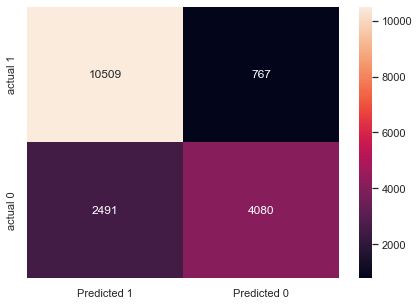

In [352]:
dt_model.fit(X_train,y_train)
y_predicted=dt_model.predict(X_test)

cm=confusion_matrix(y_test, y_predicted)
df_stacked_model = pd.DataFrame(data = cm, index = ['actual 1', 'actual 0'], columns = ['Predicted 1', 'Predicted 0'])


plt.figure(figsize = (7, 5))
sns.heatmap(df_stacked_model, annot = True,fmt='g')

print(classification_report(y_test, y_predicted))


### Random Forest

In [353]:
rf_model=RandomForestClassifier(max_depth= 15, min_samples_leaf= 2, min_samples_split=4)
rf_cv_result_acc = cross_val_score(rf_model,X, y, cv=skfold,scoring="accuracy",n_jobs=-1)
rf_cv_acc = rf_cv_result_acc.mean()*100
print('Random Forest CV Mean Accuracy Score is {}'.format(rf_cv_acc))

rf_cv_result_f1 = cross_val_score(rf_model,X, y, cv=skfold,scoring="f1",n_jobs=-1)
rf_cv_f1 = rf_cv_result_f1.mean()*100
print('Random Forest CV F1 Score  is {}'.format(rf_cv_f1))

Random Forest CV Mean Accuracy Score is 83.00554715078164
Random Forest CV F1 Score  is 73.34253196669854


              precision    recall  f1-score   support

           0       0.82      0.95      0.88     11276
           1       0.87      0.63      0.73      6571

    accuracy                           0.83     17847
   macro avg       0.84      0.79      0.80     17847
weighted avg       0.84      0.83      0.82     17847



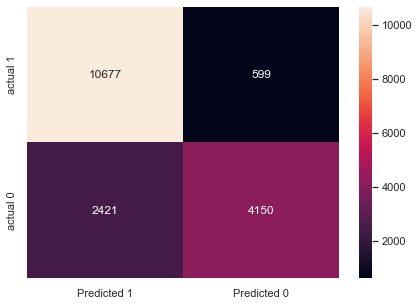

In [354]:
rf_model.fit(X_train,y_train)
y_predicted=rf_model.predict(X_test)

cm=confusion_matrix(y_test, y_predicted)
df_stacked_model = pd.DataFrame(data = cm, index = ['actual 1', 'actual 0'], columns = ['Predicted 1', 'Predicted 0'])


plt.figure(figsize = (7, 5))
sns.heatmap(df_stacked_model, annot = True,fmt='g')

print(classification_report(y_test, y_predicted))


### Logistic Regresion

In [355]:
lrg_model=LogisticRegression(C= 5, max_iter= 500, penalty='l2',class_weight= None)
# solver= 'lbfgs'
lrg_cv_result_acc = cross_val_score(lrg_model,X, y, cv=skfold,scoring="accuracy",n_jobs=-1)
lrg_cv_acc = lrg_cv_result_acc.mean()*100
print('Logistic Regression  CV Mean Accuarcy Score is {}'.format(lrg_cv_acc))

lrg_cv_result_f1 = cross_val_score(lrg_model,X, y, cv=skfold,scoring="f1",n_jobs=-1)
lrg_cv_f1 = lrg_cv_result_f1.mean()*100
print('Logistic Regression CV Mean F1 Score is {}'.format(lrg_cv_f1))

/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Logistic Regression  CV Mean Accuarcy Score is 80.6169104051101


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Logistic Regression CV Mean F1 Score is 69.30423122089525


              precision    recall  f1-score   support

           0       0.80      0.93      0.86     11276
           1       0.84      0.59      0.69      6571

    accuracy                           0.81     17847
   macro avg       0.82      0.76      0.78     17847
weighted avg       0.81      0.81      0.80     17847



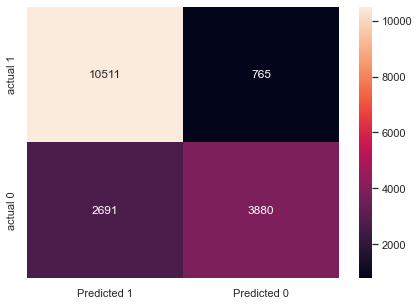

In [356]:
lrg_model.fit(X_train,y_train)
y_predicted=lrg_model.predict(X_test)

cm=confusion_matrix(y_test, y_predicted)
df_stacked_model = pd.DataFrame(data = cm, index = ['actual 1', 'actual 0'], columns = ['Predicted 1', 'Predicted 0'])


plt.figure(figsize = (7, 5))
sns.heatmap(df_stacked_model, annot = True,fmt='g')

print(classification_report(y_test, y_predicted))


### Bagging Classifier

In [377]:
bagging_model=BaggingClassifier(max_features= 0.5, max_samples= 0.3, n_estimators= 80)
bagging_cv_result_acc = cross_val_score(bagging_model,X, y, cv=skfold,scoring="accuracy",n_jobs=-1)
bagging_cv_acc = bagging_cv_result_acc.mean()*100
print('Bagging Classifier  CV Mean Accuarcy Score is {}'.format(bagging_cv_acc))

bagging_cv_result_f1 = cross_val_score(bagging_model,X, y, cv=skfold,scoring="f1",n_jobs=-1)
bagging_cv_f1 = bagging_cv_result_f1.mean()*100
print('Bagging Classifier   CV Mean F1 Score is {}'.format(bagging_cv_f1))

Bagging Classifier  CV Mean Accuarcy Score is 83.1870902672718
Bagging Classifier   CV Mean F1 Score is 73.23315024811767


              precision    recall  f1-score   support

           0       0.81      0.97      0.88     11276
           1       0.91      0.61      0.73      6571

    accuracy                           0.83     17847
   macro avg       0.86      0.79      0.81     17847
weighted avg       0.85      0.83      0.83     17847



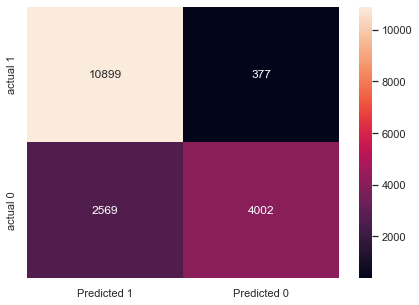

In [381]:
bagging_model.fit(X_train,y_train)
y_predicted=bagging_model.predict(X_test)

cm=confusion_matrix(y_test, y_predicted)
df_stacked_model = pd.DataFrame(data = cm, index = ['actual 1', 'actual 0'], columns = ['Predicted 1', 'Predicted 0'])


plt.figure(figsize = (7, 5))
sns.heatmap(df_stacked_model, annot = True,fmt='g')

print(classification_report(y_test, y_predicted))


# Plotting Dataframe to present the mean CV  scores of the Models


In [383]:
# Creating a dataframe to compare our models' performances:
predictive_model_scores_acc = pd.DataFrame(data=[('Random Forest',rf_cv_acc), 
                                             ('Decision Tree',dt_cv_acc),('XGBClassifier',xgb_cv_acc),('LGBClassifier',lgb_cv_acc),('Logistic Regression',lrg_cv_acc),
                                             ('Bagging Classifier',bagging_cv_acc)
                                             ],
                                       columns=['Model', 'CV_Accuracy_Score', ])
predictive_model_scores_acc

,Model,CV_Accuracy_Score
0,Random Forest,83.005547
1,Decision Tree,81.738107
2,XGBClassifier,82.976971
3,LGBClassifier,83.824172
4,Logistic Regression,80.616910
5,Bagging Classifier,83.187090


In [384]:
# Creating a dataframe to compare our models' performances:
predictive_model_scores_f1 = pd.DataFrame(data=[('Random Forest',rf_cv_f1), 
                                             ('Decision Tree',dt_cv_f1),('XGBClassifier',xgb_cv_f1),('LGBClassifier',lgb_cv_f1),('Logistic Regression',lrg_cv_f1),
                                               ('Bagging Classifier',bagging_cv_f1)],
                                       columns=['Model', 'CV_F1_Score', ])
predictive_model_scores_f1

,Model,CV_F1_Score
0,Random Forest,73.342532
1,Decision Tree,71.797501
2,XGBClassifier,73.791825
3,LGBClassifier,73.791825
4,Logistic Regression,69.304231
5,Bagging Classifier,73.233150


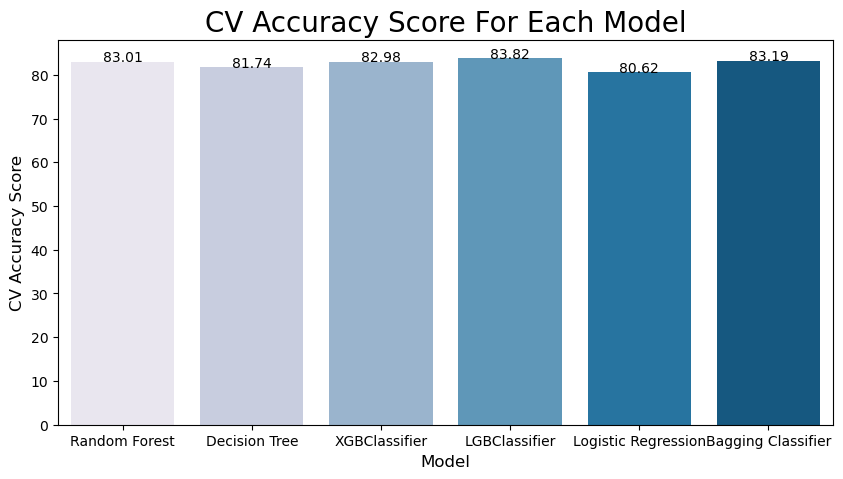

In [385]:
# Visualizing testing accuracy of each model: 
plt.style.use('default')
plt.figure(figsize=(10,5))
p=sns.barplot(x='Model', y='CV_Accuracy_Score', data=predictive_model_scores_acc, palette='PuBu')
plt.title('CV Accuracy Score For Each Model', fontsize = 20)
plt.xlabel('Model', fontsize = 12)
plt.ylabel('CV Accuracy Score', fontsize = 12)
for index, row in predictive_model_scores_acc.iterrows():
    p.text(x=row.name, y=row.CV_Accuracy_Score, s=round(row.CV_Accuracy_Score,2), color='black', horizontalalignment='center');

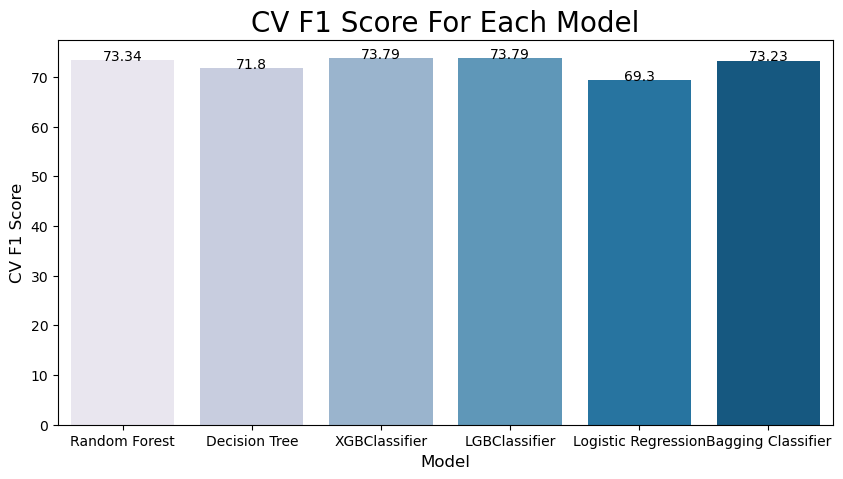

In [386]:
# Visualizing f1 score of each model: 
plt.style.use('default')
plt.figure(figsize=(10,5))
p=sns.barplot(x='Model', y='CV_F1_Score', data=predictive_model_scores_f1, palette='PuBu')
plt.title('CV F1 Score For Each Model', fontsize = 20)
plt.xlabel('Model', fontsize = 12)
plt.ylabel('CV F1 Score', fontsize = 12)
for index, row in predictive_model_scores_f1.iterrows():
    p.text(x=row.name, y=row.CV_F1_Score, s=round(row.CV_F1_Score,2), color='black', horizontalalignment='center');

# Building Ensemble Model

### Define Voting Classifier


In [281]:
from sklearn.ensemble import VotingClassifier

rf = RandomForestClassifier(max_depth= None,n_estimators=300 )
lgbm = lgb.LGBMClassifier( max_depth= 7, n_estimators=100,num_leaves=32)
xgb= XGBClassifier( max_depth=9, n_estimators= 200)

voting_clf = VotingClassifier(estimators=[('lgbm', lgbm), ('rf', rf),('xgb',xgb)], voting='soft')

cv_scores = cross_val_score(voting_clf, X_train, y_train, cv=10)

# calculate the mean and standard deviation of the cross-validation scores
mean_cv_score = cv_scores.mean()
std_cv_score = cv_scores.std()

print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", mean_cv_score)
print("Standard deviation of cross-validation scores:", std_cv_score)



[20:29:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:51] WARNING: /Users/runner/miniforge3/cond

In [282]:
skfold = StratifiedKFold(n_splits= 10,shuffle= True,random_state= 42)

scr_acc = cross_val_score(voting_clf, X, y, scoring='accuracy', cv=skfold, n_jobs=-1)
scr_f1 = cross_val_score(voting_clf, X, y, scoring='f1', cv=skfold, n_jobs=-1)

scr_cv_acc = scr_acc.mean()*100
scr_cv_f1 = scr_f1.mean()*100

print('Voting Classifier  CV Mean Accuracy Score is {}'.format(scr_cv_acc))
print('Voting Classifier CV Mean F1 Score is {}'.format(scr_cv_f1))


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hansikarunarathna/opt/anaconda3/lib/p

[20:32:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:32:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:23] WARNING: /Users/runner/miniforge3/cond

/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:33:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:33:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hansikarunarathna/opt/anaconda3/lib/p

[20:34:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:34:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:34:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:34:33] WARNING: /Users/runner/miniforge3/cond

/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:34:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:34:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:34:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hansikarunarathna/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Voting Classifier  CV Mean Accuracy Score is 85.29668851907883
Voting Classifier CV Mean F1 Score is 78.34004540653171


### Define  stacking classifier


In [279]:
from sklearn.ensemble import StackingClassifier


rf_model = RandomForestClassifier(min_samples_split=6)
lgb_model=lgb.LGBMClassifier(learning_rate=0.01, max_depth=5, num_leaves=20,n_estimators=500)
bag_model = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10, min_samples_split=5))


estimator_list = [
 ('rf_model' , rf_model),
 ('lgb_model' , lgb_model),
 ('bag',bag_model)

]

# Build stack model
stack_model = StackingClassifier(
    estimators=estimator_list, final_estimator=LogisticRegression(C=0.01,penalty="l2"), cv=5
)

cv_scores = cross_val_score(stack_model, X_train, y_train, cv=10)

# calculate the mean and standard deviation of the cross-validation scores
mean_cv_score = cv_scores.mean()
std_cv_score = cv_scores.std()

print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", mean_cv_score)
print("Standard deviation of cross-validation scores:", std_cv_score)


Cross-validation scores: [0.84273709 0.83865546 0.84465786 0.84534102 0.84414025 0.84822286
 0.84269933 0.83333333 0.83309318 0.83789625]
Mean cross-validation score: 0.8410776644951928
Standard deviation of cross-validation scores: 0.00486339280404419


In [275]:
skfold = StratifiedKFold(n_splits= 10,shuffle= True,random_state= 42)

scr_acc = cross_val_score(stack_model, X, y, scoring='accuracy', cv=skfold, n_jobs=-1)
scr_f1 = cross_val_score(stack_model, X, y, scoring='f1', cv=skfold, n_jobs=-1)

scr_cv_acc = scr_acc.mean()*100
scr_cv_f1 = scr_f1.mean()*100

print('Stacked Model CV Mean Accuracy Score is {}'.format(scr_cv_acc))
print('Stacked Model CV Mean F1 Score is {}'.format(scr_cv_f1))


Stacked Model CV Mean Accuracy Score is 84.851235501765
Stacked Model CV Mean F1 Score is 77.62415032745716


### We will select the voting classifier as our ensemble model

In [387]:
ensemble=voting_clf

### ROC Curve

In [388]:
from sklearn.metrics import roc_curve, roc_auc_score


classifiers=[ensemble]
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train.values, y_train.values)
    yproba = model.predict_proba(X_test.values)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test.values,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)





[21:54:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


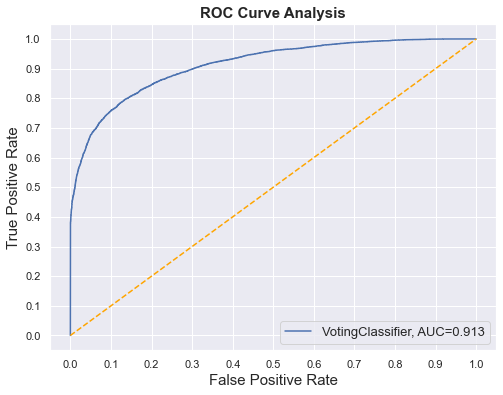

In [390]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

fig = plt.figure(figsize=(8,6))


for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

              precision    recall  f1-score   support

           0       0.85      0.93      0.89     11276
           1       0.86      0.71      0.78      6571

    accuracy                           0.85     17847
   macro avg       0.85      0.82      0.83     17847
weighted avg       0.85      0.85      0.85     17847



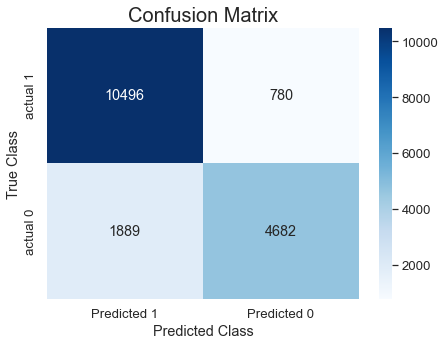

In [397]:

# visualizing the confusion matrix

y_predicted=ensemble.predict(X_test);
cm=confusion_matrix(y_test, y_predicted)
ensemble_model = pd.DataFrame(data = cm, index = ['actual 1', 'actual 0'], columns = ['Predicted 1', 'Predicted 0'])


plt.figure(figsize = (7, 5))
sns.heatmap(ensemble_model, annot = True,fmt='g',cmap="Blues")

plt.title("Confusion Matrix", size=20)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')



print(classification_report(y_test, y_predicted))

### Test the model for few properties


In [398]:
def predict_cancellation(arrival_date_month,arrival_date_day_of_month,total_stays,booking_changes,required_car_parking_spaces,customer_type,adr,previous_cancellations,market_segment,total_of_special_requests,lead_time,deposit_type):    
    customer_type_index = np.where(X.columns=='customer_type_'+customer_type)[0][0]
    market_segment_index = np.where(X.columns=='market_segment_'+market_segment)[0][0]
    deposit_type_index = np.where(X.columns=='deposit_type_'+deposit_type)[0][0]
    arrival_date_month_index = np.where(X.columns=='arrival_date_month_'+arrival_date_month)[0][0]


    x = np.zeros(len(X.columns))
    x[1] = arrival_date_day_of_month
    x[7] = total_stays
    x[3] = booking_changes
    x[5] = required_car_parking_spaces
    x[2] = previous_cancellations
    x[6] = total_of_special_requests
    x[4] = adr
    x[0] = lead_time

  


    if customer_type_index >= 0:
        x[customer_type_index] = 1

    if market_segment_index >= 0:
        x[market_segment_index] = 1

    if deposit_type_index >= 0:
        x[deposit_type_index] = 1
    
    if arrival_date_month_index >= 0:
        x[arrival_date_month_index] = 1
  

    
    return ensemble.predict([x])[0],ensemble.predict_proba([x])






In [399]:
print(predict_cancellation('July',1,3,0,0,'Transient',82,0,'Online TA',1,85,'No Deposit'))

(0, array([[0.75330581, 0.24669419]]))


### Export the tested model to a pickle file


In [400]:
import pickle
with open('ensemble_model.pickle','ab') as f:
    pickle.dump(ensemble,f)

In [ ]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}

with open("data_columns.json","w") as f:
    f.write(json.dumps(columns))